## **Introduction to Image Processing**

Mojdeh Rastgoo - Desire Sidibe

## 3. Interpolation and Blending

 Importing necessary libraries/modules and functions

In [7]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image


Pretty printing has been turned ON


### 3.1  Resizing an image size using different interpolation functions

** Q.1 Resize the `lena` or `vibot` image using nearest, bilinear and bicubic function.** 

You can define your function which accept the model and resize size from the user or just run a script.

In [8]:
def resize(image, size, method='bilinear'):
    return misc.imresize(image, size, interp=method)
    

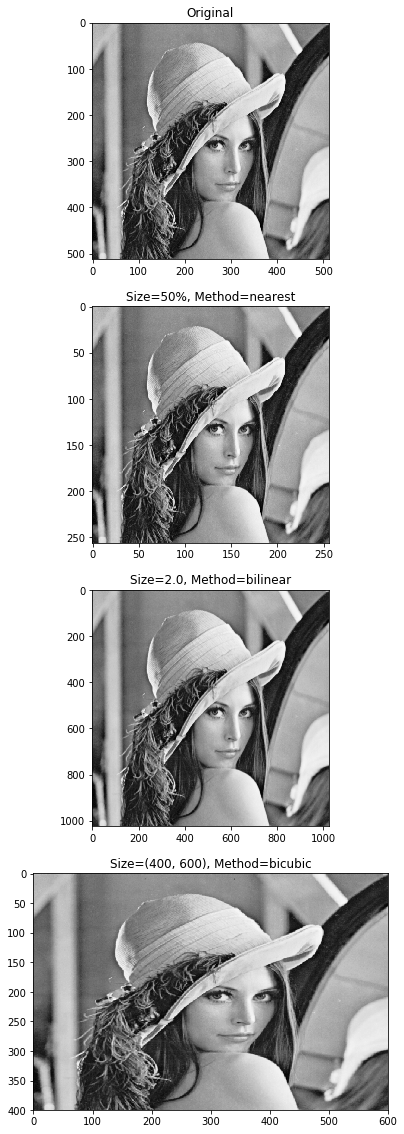

In [9]:
lena = io.imread('./images/lena-grey.bmp')

methods = ['nearest', 'bilinear', 'bicubic']
sizes = [50, 2., (400,600)]

plt.figure(figsize=(20,20))

plt.subplot(4,1,1)
plt.imshow(lena, cmap=cm.Greys_r)
plt.title("Original")

plt.subplot(4,1,2)
plt.imshow(resize(lena, size=sizes[0], method=methods[0]), cmap=cm.Greys_r)
plt.title("Size={}%, Method={}".format(sizes[0], methods[0]))

plt.subplot(4,1,3)
plt.imshow(resize(lena, size=sizes[1], method=methods[1]), cmap=cm.Greys_r)
plt.title("Size={}, Method={}".format(sizes[1], methods[1]))

plt.subplot(4,1,4)
plt.imshow(resize(lena, size=sizes[2], method=methods[2]), cmap=cm.Greys_r)
plt.title("Size={}, Method={}".format(sizes[2], methods[2]))


**Q.2 Write three functions that performs `simple_blend`, `alpha_blend` and `pyramid_blend`**

** Using your functions, blend `orange` and `apple` images together.**


In [17]:
def Laplacian_pyramid(pyramid):
    Lpyramid= []
    for i in range (0, len(pyramid)):
        if i != len(pyramid)-1:
            upscalePyramid = transform.rescale(pyramid[i+1], 2, mode='constant')
            if upscalePyramid.shape == pyramid[i].shape:
                L = pyramid[i] - upscalePyramid
                Lpyramid.append(L)
                #print 'The original image and the upscale one has the size {}'.format(upscalePyramid.shape)
            else:
                upscalePyramid = upscalePyramid[:pyramid[i].shape[0], :pyramid[i].shape[1]]
                L = pyramid[i] - upscalePyramid
                Lpyramid.append(L)
                #print 'The upscale image is cropped to be the same size as the original image {}'.format(upscalePyramid.shape)
        else:
            L = pyramid[i]
            Lpyramid.append(L)
    return Lpyramid

def colapse_pyramid(pyramid):
    Layer = len(pyramid)-1
    L = pyramid[Layer]
    while Layer != 0:      
        upscalePyramid = transform.rescale(L,2) 
        if upscalePyramid.shape == pyramid[Layer-1].shape:
            L = upscalePyramid + pyramid[Layer-1]
            Layer = Layer -1
        else:
            L = upscalePyramid[:pyramid[Layer-1].shape[0], :pyramid[Layer-1].shape[1]] + pyramid[Layer-1]
            Layer = Layer -1
    colapse_image = L         
    return colapse_image

def simple_blend(image1, image2):
    im1 = np.copy(image1)
    im2 = np.copy(image2)
    width = im1.shape[1]
    c = int(width/2)
    for i in im1:
        i[c:] = 0.
    for i in im2:
        i[:c] = 0.
    return im1 + im2

def alpha_blend(image1, image2, margin):
    im1 = np.copy(image1)
    im2 = np.copy(image2)
    width = im1.shape[1]
    center = int(width/2)
    x1 = center - margin
    x2 = center + margin
    x = np.arange(x1,x2+1)
    y = np.arange(float(x2-x1+1))/(x2-x1)
    y_rev = y[::-1]
    for i in im1:
        i[x1:x2+1] = i[x1:x2+1] * y_rev
        i[x2+1:] = 0.
    for i in im2:
        i[x1:x2+1] = i[x1:x2+1] * y
        i[:x1] = 0.
    return im1 + im2
    #return im1 * alpha + im2 * (1-alpha)
    
def pyramid_blend(image1, image2):
    im1 = np.copy(image1)
    im2 = np.copy(image2)
    row, col = np.shape(im1)
    ## Create a region mask 
    mask = np.zeros(im1.shape)
    mask[:,:int(col/2)] = 1.0
    mask[:, int(col/2):] = 0.0
    ## Gaussian pyramid for im1 and im2   
    im1_GP = transform.pyramid_gaussian(im1, downscale=2)
    im1_GP = list(im1_GP)
    print (len(im1_GP))
    im1_GP = [a for a in im1_GP]
    im2_GP = transform.pyramid_gaussian(im2, downscale=2)
    im2_GP = [a for a in im2_GP]
    ## Laplacian pyramid using the equation of blending
    im1_LP = Laplacian_pyramid(im1_GP)
    im2_LP = Laplacian_pyramid(im2_GP)
    ## Gaussian pyramid for mask
    mask_GP = tuple(transform.pyramid_gaussian(mask, downscale=2))
    mask_GP = [a for a in mask_GP]
    ## Blending the two laplacian pyramid
    Blend_pyramid = []
    for i in range(0, len(mask_GP)):
        Blend_pyramid.append(im1_LP[i]*mask_GP[i] + im2_LP[i]*(1 - mask_GP[i]))
    ## Colapsing the blending pyramid 
    blend_im = colapse_pyramid(Blend_pyramid)
    return blend_im

In [11]:
orange = io.imread('./images/orange.jpeg', as_grey=1)
apple = io.imread('./images/apple.jpeg', as_grey=1)

10
10


C:\Programs\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


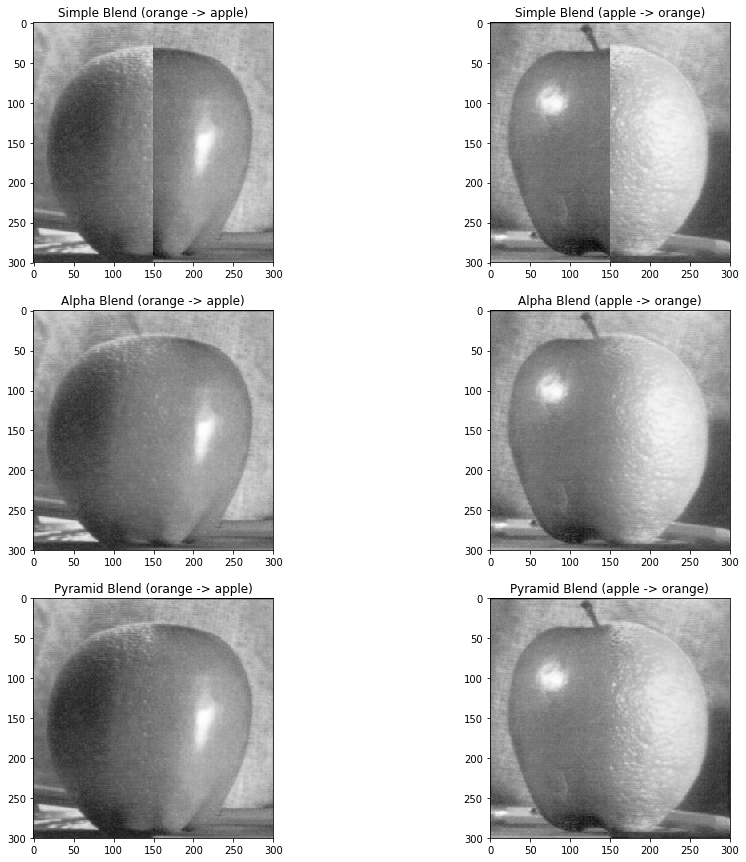

In [18]:
plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.imshow(simple_blend(orange, apple), cmap=cm.Greys_r)
plt.title("Simple Blend (orange -> apple)")
plt.subplot(3,2,2)
plt.imshow(simple_blend(apple, orange), cmap=cm.Greys_r)
plt.title("Simple Blend (apple -> orange)")

margin = 50
plt.subplot(3,2,3)
plt.imshow(alpha_blend(orange, apple, margin), cmap=cm.Greys_r)
plt.title("Alpha Blend (orange -> apple)")
plt.subplot(3,2,4)
plt.imshow(alpha_blend(apple, orange, margin), cmap=cm.Greys_r)
plt.title("Alpha Blend (apple -> orange)")

plt.subplot(3,2,5)
plt.imshow(pyramid_blend(orange, apple), cmap=cm.Greys_r)
plt.title("Pyramid Blend (orange -> apple)")
plt.subplot(3,2,6)
plt.imshow(pyramid_blend(apple, orange), cmap=cm.Greys_r)
plt.title("Pyramid Blend (apple -> orange)")
